### Import modules

In [1]:
import os
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.decomposition import PCA, TruncatedSVD, IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
import math
from sklearn.multioutput import MultiOutputRegressor
import sklearn.neural_network as skl_nn

from sklearn.metrics import mean_squared_error
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())
def print_score(m):
    res =[rmse(m.predict(X_train_scaled),y_train),rmse(m.predict(X_test_scaled),y_test),m.score(X_train_scaled,y_train),m.score(X_test_scaled,y_test)]
    if hasattr(m,'oob_score_'):res.append(m.oob_score_)
    print(res)

### Set path to raw data (path) and postprocessed data (pdata_loc)

In [3]:
path='/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/'
pdata_loc = '/p/lustre1/lassman1/a2e-mmc/WIND_ML/batch_postprocessing/production_runs_2hours/'

# Building Surrogates

In [4]:
# Tau13 vertical profile, color a function of cases

DX=[6,12,18,24,30,36,48]

DZ=['2.0','2.4','3.0','4.0','4.5','5.0','6.0','7.2','7.5','8.0','9.0','10.0','12.0','15.0','18.0']

case_colormap = plt.cm.plasma(np.linspace(0, 1, np.int(0.5*len(DX)*len(DZ)) ))

dx_list=[]
dz_list=[]
f_list=[]
pf_list=[]

case=[]
p=0
q=0
for dx in DX:
    p=p+1
    for dz in DZ:
        delta_t='1H'
        alpha=str(round(dx/np.float(dz),1))
        folder=f'DX_{dx}_DZ_{dz}_ALPHA_{alpha}'
        pdata_3D = f'pdata_3D_DX_{dx}_DZ_{dz}_ALPHA_{alpha}.nc'

        if os.path.exists(path+folder):
            if os.path.exists(pdata_loc + pdata_3D):
                try:
                    q=q+1
                    dx_list.append(dx)
                    dz_list.append(dz)
                    img=xr.open_dataset(pdata_loc + f'time_average_spectra_{delta_t}_{folder}.nc')
                    img['U_p_norm_power'] = img.U_p * img.frequency
                    img['W_p_norm_power'] = img.W_p * img.frequency
                    f_list.append(img.frequency)
                    pf_list.append(img.U_p_norm_power.isel(XTIME = 0, nz = 0))
                except FileNotFoundError:
                    print(f'Simulation not run = {dx}, {dz}')

/g/g92/mgf/my_personal_env/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/mgf/my_personal_env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [5]:
dx_np=np.array(dx_list)
dz_np=np.array(dz_list)
f_np=np.array(f_list)
pf_np=np.array(pf_list)

In [6]:
l=[]
for i in range(len(f_list)):
    l.append(len(f_list[i]))
longest=np.max(l)

pca_data=np.zeros([35,2,longest])

In [7]:
def ext_func(data,new_length): 
    old_indices = np.arange(0,len(data))
    new_indices = np.linspace(0,len(data)-1,new_length)
    spl = UnivariateSpline(old_indices,data,k=3,s=0)
    return spl(new_indices)

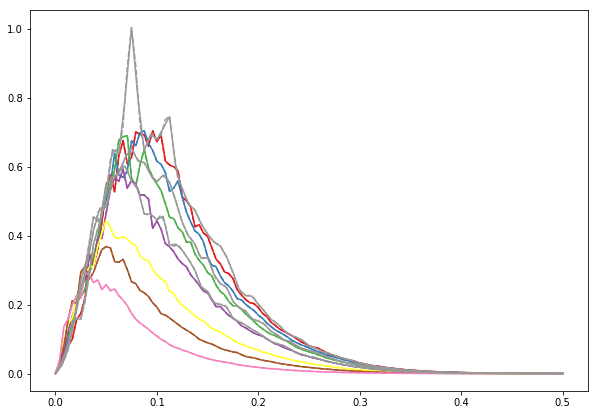

In [8]:
#Splines to make length consistent

plt.figure(figsize=(10,7))
case_colormap = plt.cm.Set1(np.linspace(0, 5, len(f_list) ))


for i in range(len(f_list)):
    df1=f_list[i].to_dataframe().iloc[:,-1].reset_index(drop=True)
    pca_data[i,0,:]=ext_func(df1,longest)
    df2=pf_list[i].to_dataframe().iloc[:,-1].reset_index(drop=True)
    pca_data[i,1,:]=ext_func(df2,longest)


for i in range(10):#(len(f_list)):
    df1 = f_list[i].to_dataframe().iloc[:,-1].reset_index(drop=True)
    df2 = pf_list[i].to_dataframe().iloc[:,-1].reset_index(drop=True)
    plt.plot(df1,df2,'-',color=case_colormap[i])
    plt.plot(ext_func(df1,longest),ext_func(df2,longest),'--',color=case_colormap[i])

In [9]:
#Now we drop the frequencies (x-axis) beause they are all the same and they will not be use to train surrogates.
print(pca_data.shape)
pca_data=pca_data[:,1,:]
print(pca_data.shape)

(35, 2, 121)
(35, 121)


In [15]:
#Principal component analysis fitting
pca_reductor = PCA()#PCA(0.95)
pca_reductor.fit(pca_data)

PCA()

components= 35


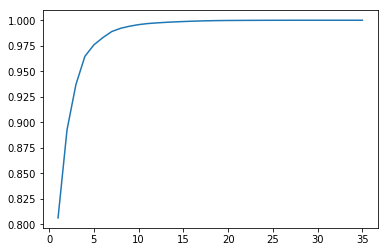

In [16]:
components=len(pca_reductor.components_)
print('components=', components)
plt.figure()
plt.plot(np.linspace(1,components,components),np.cumsum(pca_reductor.explained_variance_ratio_)) #(ratio 4 components)

/collab/usr/gapps/python/build/spack-toss3.3/opt/spack/linux-rhel7-x86_64/gcc-4.9.3/python-3.7.2-asydydmavj2puklmx5t6cu3ruzmg2b3a/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


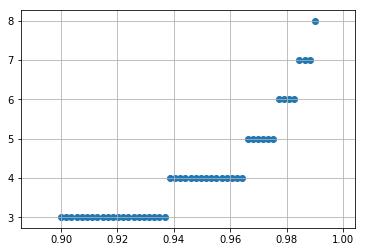

In [17]:
explained_variance=np.linspace(0.9,0.99,50)
components=[]
for i in explained_variance:
    pca_reductor = PCA(i)
    pca_reductor.fit(pca_data)
    components.append(len(pca_reductor.components_))

plt.scatter(explained_variance,components)
plt.grid('on')

components= 8


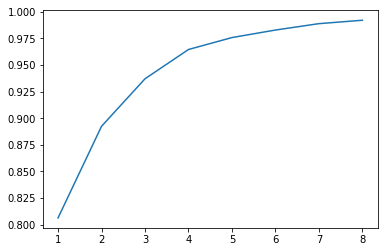

In [18]:
#Only 8 components can give us great explained variance (99%)
pca_reductor = PCA(0.99)
pca_reductor.fit(pca_data)
components=len(pca_reductor.components_)
print('components=', components)
plt.figure()
plt.plot(np.linspace(1,components,components),np.cumsum(pca_reductor.explained_variance_ratio_)) #(ratio 4 components)

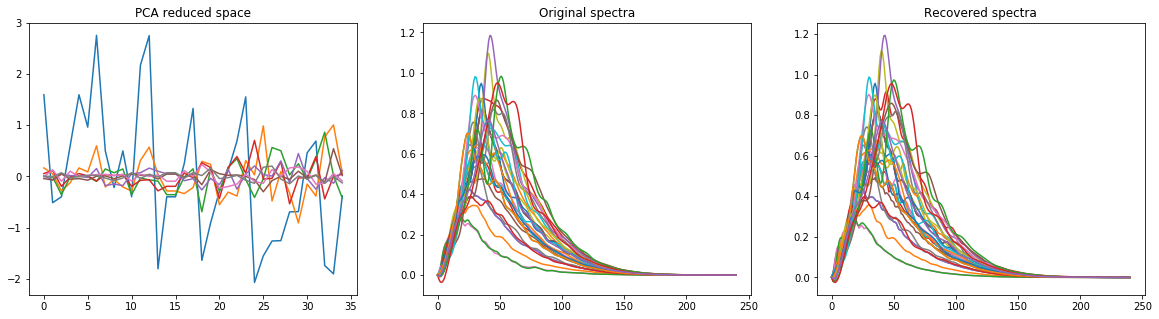

In [65]:
#Let us visualize the prediction and compare with the original data
reduced_output_data=pca_reductor.transform(pca_data)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.title('PCA reduced space')
a=plt.plot(reduced_output_data)
plt.subplot(1,3,2)
plt.title('Original spectra')
b=plt.plot(pca_reductor.inverse_transform(reduced_output_data).T)
plt.subplot(1,3,3)
plt.title('Recovered spectra')
b=plt.plot(pca_data.T)

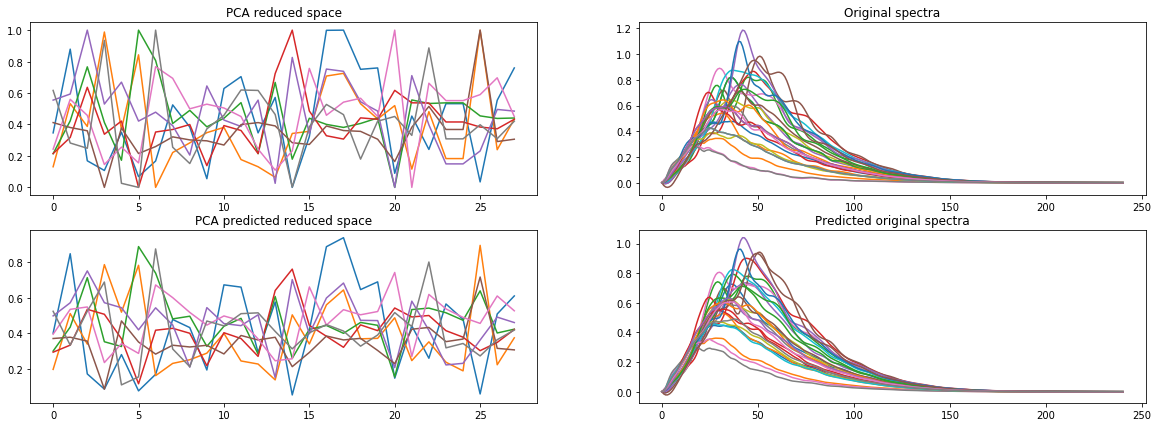

In [142]:
#Training data, recober perfectly by PCA

plt.figure(figsize=(20,7))
plt.subplot(2,2,1)
plt.title('PCA reduced space')
a=plt.plot(y_train_scaled)

plt.subplot(2,2,2)
plt.title('Original spectra')
b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_train_scaled)).T)

plt.subplot(2,2,3)
plt.title('PCA predicted reduced space')
pred_train=RF_model.predict(X_train_scaled)
a=plt.plot(pred_train)

plt.subplot(2,2,4)
plt.title('Predicted original spectra')
b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_train)).T)

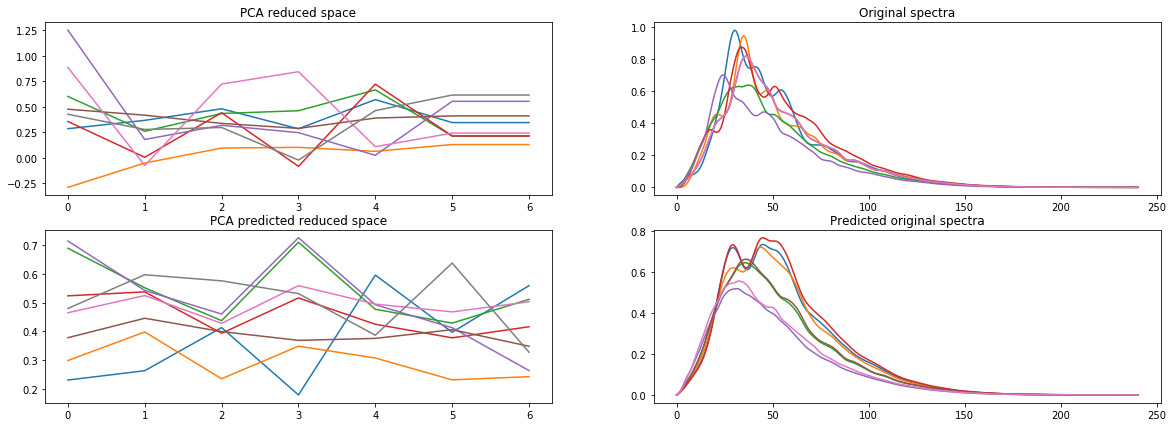

In [144]:
#Test data, recovering the overal shape by PCA


plt.figure(figsize=(20,7))
plt.subplot(2,2,1)
plt.title('PCA reduced space')
a=plt.plot(y_test_scaled)

plt.subplot(2,2,2)
plt.title('Original spectra')
b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_test_scaled)).T)

plt.subplot(2,2,3)
plt.title('PCA predicted reduced space')
pred_test=RF_model.predict(X_test_scaled)
a=plt.plot(pred_test)

plt.subplot(2,2,4)
plt.title('Predicted original spectra')
b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_test)).T)

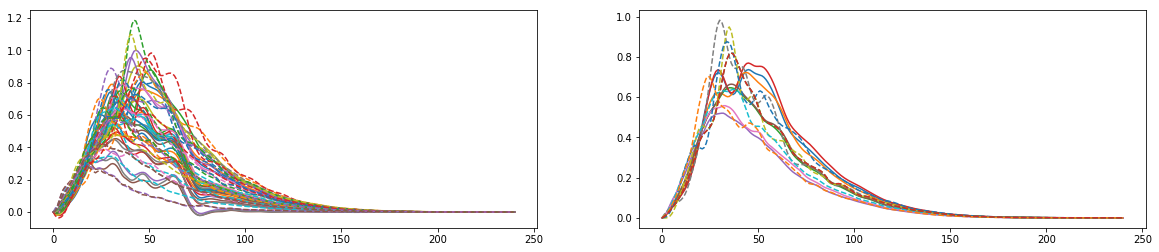

In [145]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred)).T) #Pred
b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_train_scaled)).T,'--') #Ground truth
plt.subplot(1,2,2)
b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_test)).T)#Pred
b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_test_scaled)).T,'--')# Ground truth

Training data - Random Forest


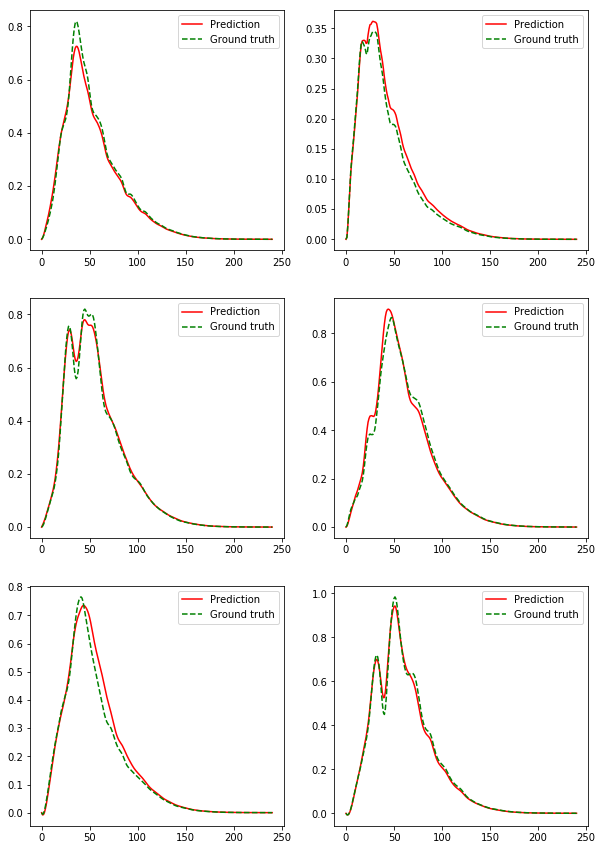

In [146]:
#Training data, a closer look at the PCA performance

n=3
plt.figure(figsize=(10,15))
print('Training data - Random Forest')
for i in range(2*n):
    plt.subplot(n,2,i+1)
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_train)).T[:,i],'r',label='Prediction')
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_train_scaled)).T[:,i],'g--',label='Ground truth')
    plt.legend()
plt.show()

Test data - Random Forest


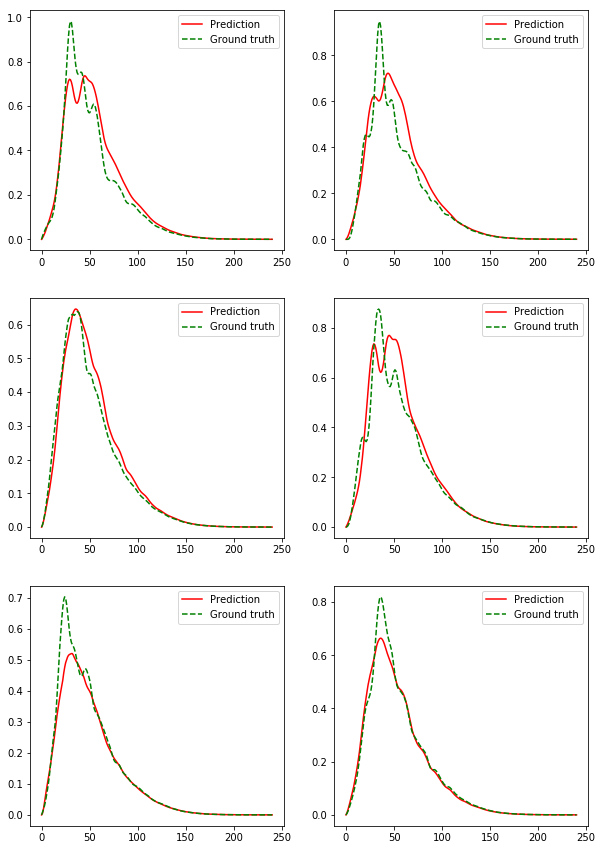

In [147]:
#Test, a closer look at the PCA performance
n=3
plt.figure(figsize=(10,15))
print('Test data - Random Forest')
for i in range(2*n):
    plt.subplot(n,2,i+1)
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_test)).T[:,i],'r',label='Prediction')
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_test_scaled)).T[:,i],'g--',label='Ground truth')
    plt.legend()

R2 train:0.8319332029601111
R2 test:-0.8550617289257334
RMSE: 0.283798


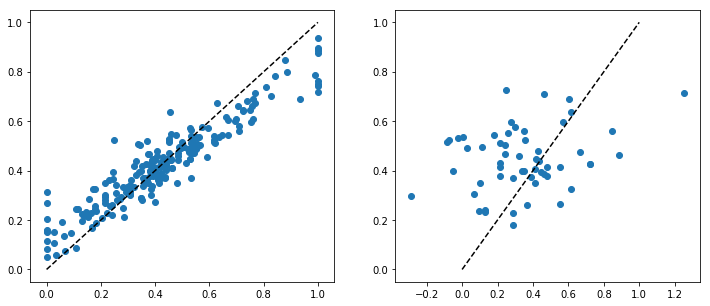

In [141]:
# Random Forest Custom values, not working very well on the test data

RF_model=RandomForestRegressor(
    n_estimators=50,
    criterion='mse',
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
)
                               
RF_model.fit(X_train_scaled,y_train_scaled)
print(f'R2 train:{RF_model.score(X_train_scaled,y_train_scaled)}')

preds = RF_model.predict(X_test_scaled)
print(f'R2 test:{RF_model.score(X_test_scaled,y_test_scaled)}')
rmse = np.sqrt(mean_squared_error(y_test_scaled, preds))
print("RMSE: %f" % (rmse))

lb=np.min(y_train_scaled);ub=np.max(y_train_scaled)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_train_scaled,RF_model.predict(X_train_scaled))
plt.plot([lb,ub],[lb,ub],'k--')
plt.subplot(1,2,2)
plt.scatter(y_test_scaled,RF_model.predict(X_test_scaled))
plt.plot([lb,ub],[lb,ub],'k--')

In [ ]:
#Preparing the data for the alternative surrogate model random forest

input_data=np.array([dx_np,dz_np]).astype('float64').T

X, y = input_data,reduced_output_data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

inputs_scaler=MinMaxScaler()

X_train_scaled= inputs_scaler.fit_transform(X_train)
X_test_scaled= inputs_scaler.transform(X_test)


outputs_scaler=MinMaxScaler()

y_train_scaled= outputs_scaler.fit_transform(y_train)
y_test_scaled= outputs_scaler.transform(y_test)

R2 train:0.9204857260578984
R2 test:-1.1648179652365067
RMSE: 0.153413


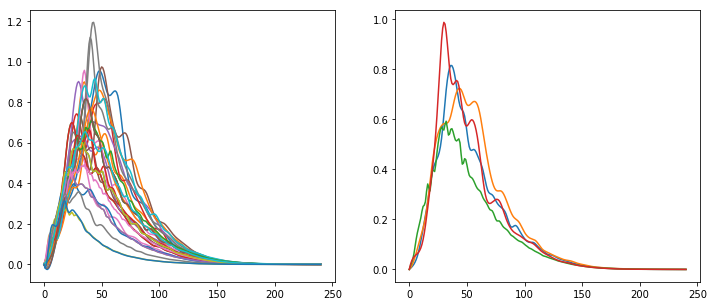

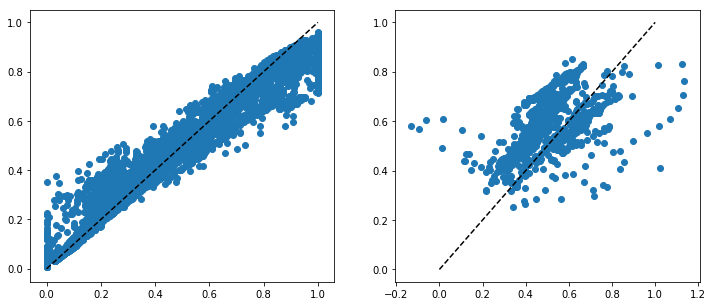

In [30]:
# Random Forest training

X, y = input_data,pca_data

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)
[X_test.shape,y_test.shape]

inputs_scaler=MinMaxScaler()

X_train_scaled= inputs_scaler.fit_transform(X_train)
X_test_scaled= inputs_scaler.transform(X_test)


outputs_scaler=MinMaxScaler()

y_train_scaled= outputs_scaler.fit_transform(y_train)
y_test_scaled= outputs_scaler.transform(y_test)


RF_model=RandomForestRegressor()
RF_model.fit(X_train_scaled,y_train_scaled)
print(f'R2 train:{RF_model.score(X_train_scaled,y_train_scaled)}')


preds = RF_model.predict(X_test_scaled)
print(f'R2 test:{RF_model.score(X_test_scaled,y_test_scaled)}')
rmse = np.sqrt(mean_squared_error(y_test_scaled, preds))
print("RMSE: %f" % (rmse))


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_train.T)
plt.subplot(1,2,2)
plt.plot(y_test.T)

lb=np.min(y_train_scaled);ub=np.max(y_train_scaled)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_train_scaled,RF_model.predict(X_train_scaled))
plt.plot([lb,ub],[lb,ub],'k--')
plt.subplot(1,2,2)
plt.scatter(y_test_scaled,RF_model.predict(X_test_scaled))
plt.plot([lb,ub],[lb,ub],'k--')

R2 train:0.9998869236823887
R2 test:-2.364874717162886
RMSE: 0.324713


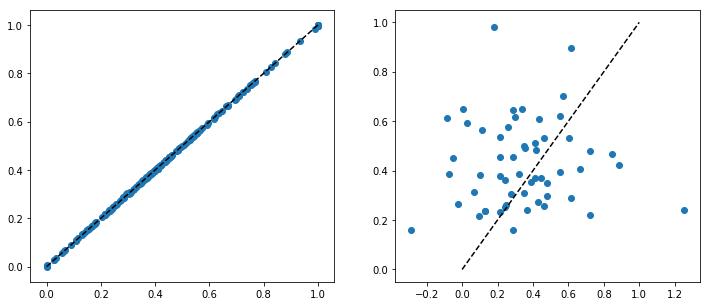

In [148]:
# XGBoost training

XGB_model= MultiOutputRegressor(xgb.XGBRegressor())
XGB_model.fit(X_train_scaled,y_train_scaled)
print(f'R2 train:{XGB_model.score(X_train_scaled,y_train_scaled)}')


preds = XGB_model.predict(X_test_scaled)
print(f'R2 test:{XGB_model.score(X_test_scaled,y_test_scaled)}')
rmse = np.sqrt(mean_squared_error(y_test_scaled, preds))
print("RMSE: %f" % (rmse))

lb=np.min(y_train_scaled);ub=np.max(y_train_scaled)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_train_scaled,XGB_model.predict(X_train_scaled))
plt.plot([lb,ub],[lb,ub],'k--')
plt.subplot(1,2,2)
plt.scatter(y_test_scaled,XGB_model.predict(X_test_scaled))
plt.plot([lb,ub],[lb,ub],'k--')

Training data - XBG


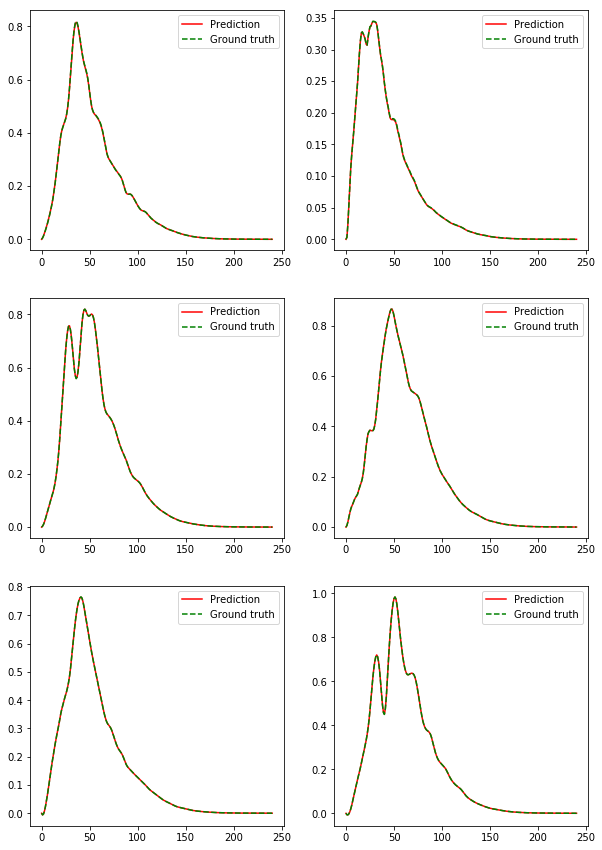

In [149]:
#Train, XGBoost performance
n=3
pred_train=XGB_model.predict(X_train_scaled)
plt.figure(figsize=(10,15))
print('Training data - XBG')
for i in range(2*n):
    plt.subplot(n,2,i+1)
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_train)).T[:,i],'r',label='Prediction')
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_train_scaled)).T[:,i],'g--',label='Ground truth')
    plt.legend()
plt.show()

Test data - XGB


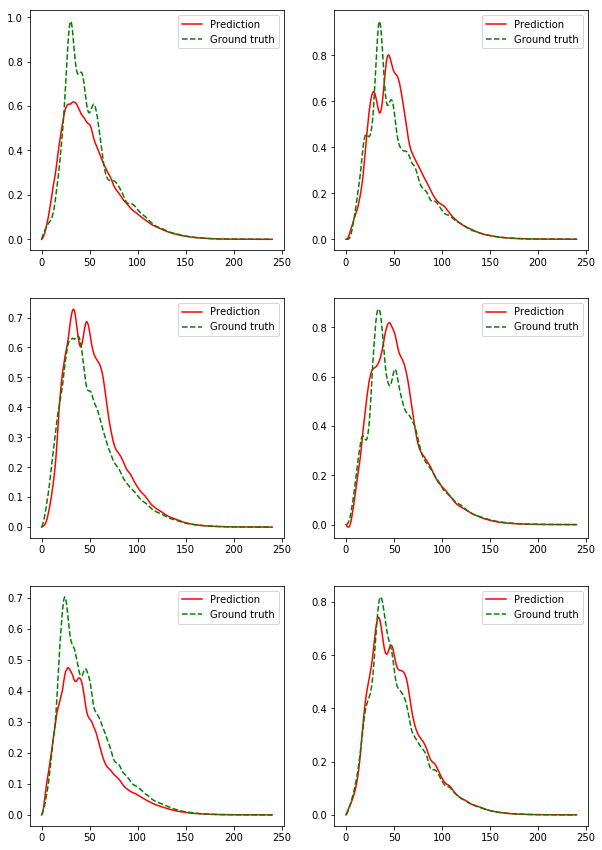

In [150]:
#Test, XGboost performance
n=3
pred_test=XGB_model.predict(X_test_scaled)
plt.figure(figsize=(10,15))
print('Test data - XGB')
for i in range(2*n):
    plt.subplot(n,2,i+1)
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_test)).T[:,i],'r',label='Prediction')
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_test_scaled)).T[:,i],'g--',label='Ground truth')
    plt.legend()
plt.show()

In [151]:
# NN 

nn_model = skl_nn.MLPRegressor(
            hidden_layer_sizes=(300,400,300,), alpha=1.e-5, tol=1.e-10, 
            activation='relu', solver='adam', learning_rate='adaptive', 
            max_iter=50000, 
            random_state=12345,verbose=True,n_iter_no_change=100)


nn_model.fit(X_train_scaled,y_train_scaled)

Iteration 1, loss = 0.17835985
Iteration 2, loss = 0.12289765
Iteration 3, loss = 0.08134391
Iteration 4, loss = 0.05212030
Iteration 5, loss = 0.03471443
Iteration 6, loss = 0.02989112
Iteration 7, loss = 0.03378711
Iteration 8, loss = 0.03824287
Iteration 9, loss = 0.03835828
Iteration 10, loss = 0.03495934
Iteration 11, loss = 0.03083718
Iteration 12, loss = 0.02786353
Iteration 13, loss = 0.02646710
Iteration 14, loss = 0.02626634
Iteration 15, loss = 0.02652455
Iteration 16, loss = 0.02668458
Iteration 17, loss = 0.02645684
Iteration 18, loss = 0.02585469
Iteration 19, loss = 0.02500321
Iteration 20, loss = 0.02410074
Iteration 21, loss = 0.02331540
Iteration 22, loss = 0.02274146
Iteration 23, loss = 0.02242085
Iteration 24, loss = 0.02227810
Iteration 25, loss = 0.02219484
Iteration 26, loss = 0.02207429
Iteration 27, loss = 0.02186193
Iteration 28, loss = 0.02156610
Iteration 29, loss = 0.02124576
Iteration 30, loss = 0.02096142
Iteration 31, loss = 0.02074858
Iteration 32, los

MLPRegressor(alpha=1e-05, hidden_layer_sizes=(300, 400, 300),
             learning_rate='adaptive', max_iter=50000, n_iter_no_change=100,
             random_state=12345, tol=1e-10, verbose=True)

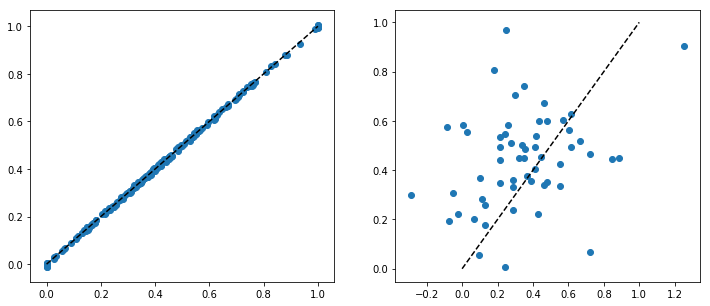

In [152]:
lb=np.min(y_train_scaled);ub=np.max(y_train_scaled)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_train_scaled,nn_model.predict(X_train_scaled))
plt.plot([lb,ub],[lb,ub],'k--')
plt.subplot(1,2,2)
plt.scatter(y_test_scaled,nn_model.predict(X_test_scaled))
plt.plot([lb,ub],[lb,ub],'k--')

Training data - Neural Networks


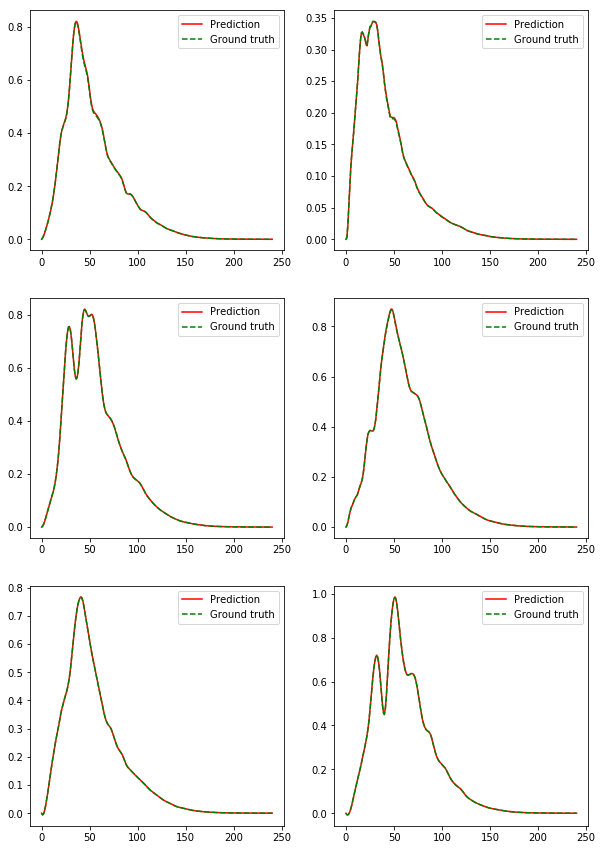

In [153]:
#Train, NN performance
n=3
pred_train=nn_model.predict(X_train_scaled)
plt.figure(figsize=(10,15))
print('Training data - Neural Networks')
for i in range(2*n):
    plt.subplot(n,2,i+1)
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_train)).T[:,i],'r',label='Prediction')
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_train_scaled)).T[:,i],'g--',label='Ground truth')
    plt.legend()
plt.show()

Test data - Neural Networks


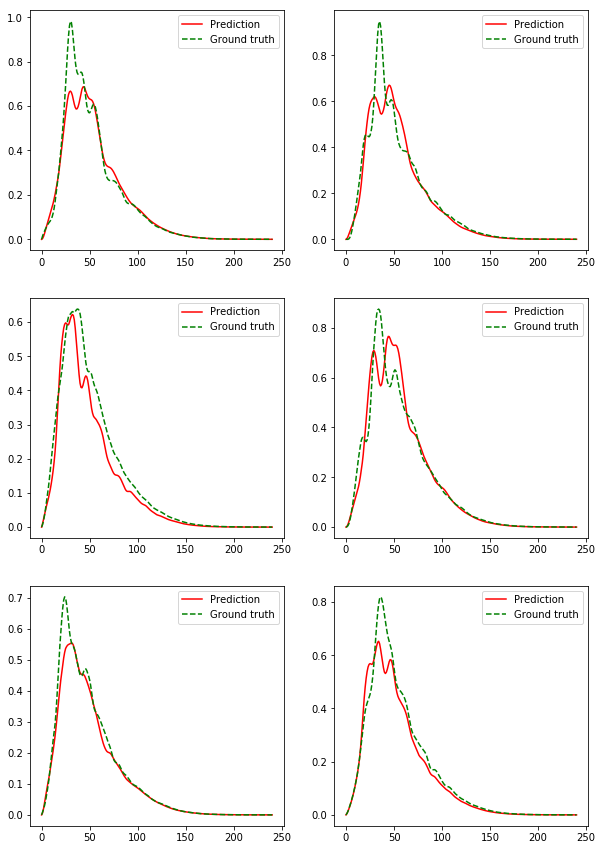

In [154]:
#Test, NN performance
n=3
pred_test=nn_model.predict(X_test_scaled)
plt.figure(figsize=(10,15))
print('Test data - Neural Networks')
for i in range(2*n):
    plt.subplot(n,2,i+1)
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_test)).T[:,i],'r',label='Prediction')
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_test_scaled)).T[:,i],'g--',label='Ground truth')
    plt.legend()
plt.show()

In [156]:
nn_model = skl_nn.MLPRegressor(
            hidden_layer_sizes=(1000,1000,1000,), alpha=1.e-5, tol=1.e-10, 
            activation='relu', solver='adam', learning_rate='adaptive', 
            max_iter=50000, 
            random_state=12345,verbose=True,n_iter_no_change=100)


nn_model.fit(X_train_scaled,y_train_scaled)

Iteration 1, loss = 0.11782212
Iteration 2, loss = 0.04426079
Iteration 3, loss = 0.02821117
Iteration 4, loss = 0.04204185
Iteration 5, loss = 0.03201732
Iteration 6, loss = 0.02471650
Iteration 7, loss = 0.02548024
Iteration 8, loss = 0.02752278
Iteration 9, loss = 0.02742047
Iteration 10, loss = 0.02548728
Iteration 11, loss = 0.02321969
Iteration 12, loss = 0.02181100
Iteration 13, loss = 0.02156807
Iteration 14, loss = 0.02187265
Iteration 15, loss = 0.02189724
Iteration 16, loss = 0.02142174
Iteration 17, loss = 0.02072874
Iteration 18, loss = 0.02016870
Iteration 19, loss = 0.01991499
Iteration 20, loss = 0.01988881
Iteration 21, loss = 0.01982061
Iteration 22, loss = 0.01958905
Iteration 23, loss = 0.01921877
Iteration 24, loss = 0.01878881
Iteration 25, loss = 0.01844597
Iteration 26, loss = 0.01826902
Iteration 27, loss = 0.01818760
Iteration 28, loss = 0.01807181
Iteration 29, loss = 0.01785270
Iteration 30, loss = 0.01755843
Iteration 31, loss = 0.01728229
Iteration 32, los

MLPRegressor(alpha=1e-05, hidden_layer_sizes=(1000, 1000, 1000),
             learning_rate='adaptive', max_iter=50000, n_iter_no_change=100,
             random_state=12345, tol=1e-10, verbose=True)

Training data - Neural Networks


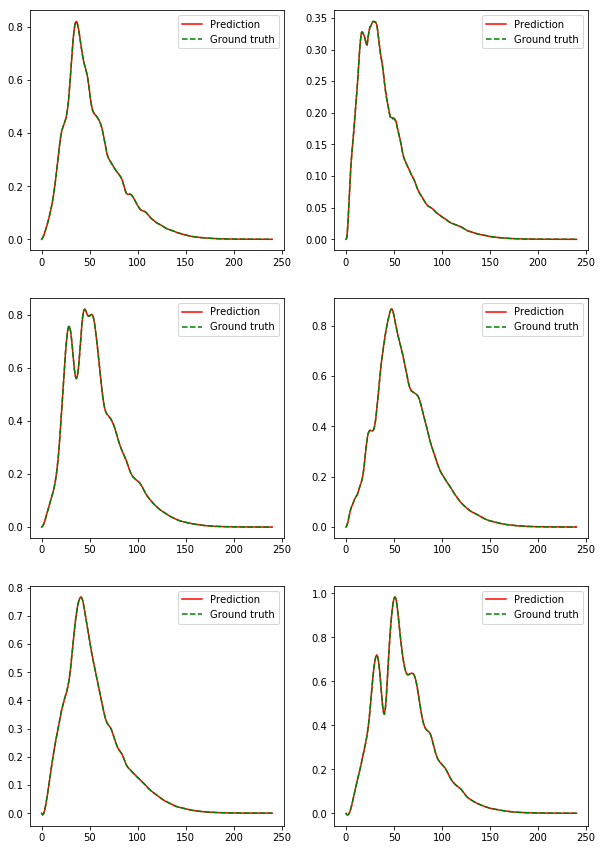

In [157]:
#Train, NN performance
n=3
pred_train=nn_model.predict(X_train_scaled)
plt.figure(figsize=(10,15))
print('Training data - Neural Networks')
for i in range(2*n):
    plt.subplot(n,2,i+1)
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_train)).T[:,i],'r',label='Prediction')
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_train_scaled)).T[:,i],'g--',label='Ground truth')
    plt.legend()
plt.show()

Test data - Neural Networks


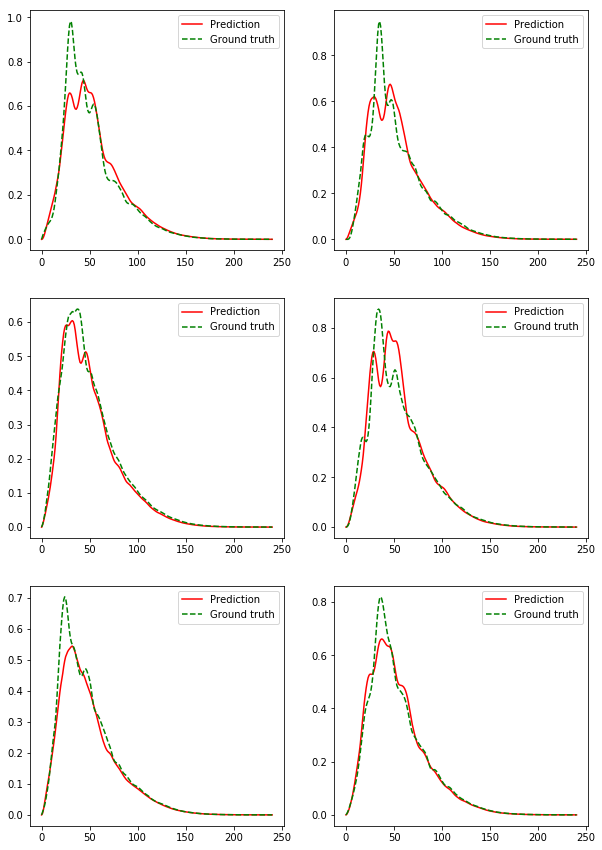

In [158]:
#Test, NN performance
n=3
pred_test=nn_model.predict(X_test_scaled)
plt.figure(figsize=(10,15))
print('Test data - Neural Networks')
for i in range(2*n):
    plt.subplot(n,2,i+1)
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_test)).T[:,i],'r',label='Prediction')
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_test_scaled)).T[:,i],'g--',label='Ground truth')
    plt.legend()
plt.show()

In [ ]:
#Grid search, this tool helps to optimize hyperparameters

n_estimators = [int(x) for x in np.arange(start = 10, stop = 2000, step = 10)]
max_features = [0.5,'auto', 'sqrt','log2']
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# First create the base model to tune
RF_model = RandomForestRegressor()
# Fit the random search model
RF_model_random = RandomizedSearchCV(estimator = RF_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
RF_model_random.fit(X_train, y_train)
RF_model_random.best_params_